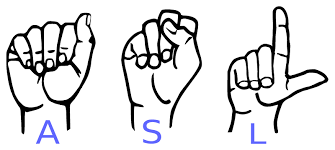 

The American Sign Language consists of 29 different signs for the 26 alphabets, space, delete and nothing. This notebook performs image classification on these 29 classes and is trained on the ASL dataset consisting of over 70,000 sign language images. 

This notebook is divided into the following sections.

0. [Importing required Libraries](#0)
1. [Loading the dataset](#1)
2. [Data Visualization](#2)
3. [Performing Data Preprocessing](#3)
4. [Defining custom Convolutional Neural Network](#4)
5. [Training the model on the data](#5)
6. [Model evaluation](#6)

Let's get started!

## 0. Import Libraries
<div id="0">
</div>

Before starting with the dataset, we require to import certain libraries to aid us in data preprocessing, visualisation and training. They are imported as shown below.

In [ ]:
# To check if GPU is active
from tensorflow.python.client import device_lib

# Load Data
import os
import cv2
import numpy as np

# Data Visualisation
import matplotlib.pyplot as plt

# Model Training
from tensorflow.keras import utils
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from sklearn.model_selection import train_test_split

As we would be training a CNN model, a GPU would speed up the training process by manifolds whereas the model would take hours to train on a CPU. Hence, let's verify the presence of a GPU below. 

If the GPU is not available, you can turn it on by clicking at the three dots on the top right, going to Accelerators and clicking on your preferred GPU option.

In [ ]:
print(device_lib.list_local_devices())

## 1. Load Data
<div id="1">
</div>

The ASL Dataset contains 29 classes of images, including all the alphabets, delete, space and nothing. The data is divided into two folders for test and training purposes. 

Here, we would use the training data for training and validation purposes. The test data would be used later for model evaluation.

Let us define the data directories now.

In [ ]:
train_dir = '../input/asl-alphabet/asl_alphabet_train/asl_alphabet_train'
test_dir = '../input/asl-alphabet/asl_alphabet_test/asl_alphabet_test'

To obtain image data, let us read the folders of all classes and store them inside single arrays of images (X)and their corresponding labels (y). Since we are reading and storing 87,000 images, this step would require some time to finish.

In [ ]:
def get_data(data_dir) :
    images = []
    labels = []
    
    dir_list = os.listdir(data_dir)
    for i in range(len(dir_list)):
        print("Obtaining images of", dir_list[i], "...")
        for image in os.listdir(data_dir + "/" + dir_list[i]):
            img = cv2.imread(data_dir + '/' + dir_list[i] + '/' + image)
            img = cv2.resize(img, (32, 32))
            images.append(img)
            labels.append(i)
    
    return images, labels
        
X, y = get_data(train_dir)

Before moving forward, let us verify the size of both X and y, to ensure all the data is read.

In [ ]:
print(len(X), len(y))

## 2. Data Visualisation
<div id="2">
</div>

Before preprocessing our data, let us explore and gain insight into the images we are dealing with. For simplicity, let us load one sample image from each class.

In [ ]:
classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 
           'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 
           'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']

In [ ]:
def plot_sample_images():
    figure = plt.figure()
    plt.figure(figsize=(16,5))

    for i in range (0,29):
        plt.subplot(3,10,i+1)
        plt.xticks([])
        plt.yticks([])
        path = train_dir + "/{0}/{0}1.jpg".format(classes[i])
        img = plt.imread(path)
        plt.imshow(img)
        plt.xlabel(classes[i])
        
plot_sample_images()

We can observe various sign language images as seen above. These denote different alphabets and symbols that our model would be trained to recognize. 

## 3. Data Preprocessing
<div id="3">
</div>

Before feeding the data to our model, we convert into numpy arrays and normalise the values by dividing the image pixel values by 255. 

Then, we divide our training data into training and testing sets to be used by the model. 

In [ ]:
def preprocess_data(X, y):
    np_X = np.array(X)
    normalised_X = np_X.astype('float32')/255.0
    
    label_encoded_y = utils.to_categorical(y)
    
    x_train, x_test, y_train, y_test = train_test_split(normalised_X, label_encoded_y, test_size = 0.1)
    
    return x_train, x_test, y_train, y_test

x_train, x_test, y_train, y_test = preprocess_data(X, y)

Let us confirm the size of training and testing data.

In [ ]:
print("Training data:", x_train.shape)
print("Test data:", x_test.shape)

## 4. Define CNN Model
<div id="4">
</div>

Next, we define the architecture of our custom CNN Model. 

I have trained the model for 15 epochs, with the standard batch size of 32. Feel free to experiment with them for your use cases.

In [ ]:
classes = 29
batch = 32
epochs = 15
learning_rate = 0.001

For our model, let us initialize a Keras Sequential model. 

The defined model is a 4 layer deep CNN model. Batch normalisation and dropout layers have been added to avoid overfitting on the training set and perform regularization. Max pooling is also applied.

The three CNN layers have been flattened out and connected to a dense layer before performing classification using the softmax activation function.

This model is created by experimenting with various layers to achieve the maximum validation accuracy.

In [ ]:
model = Sequential()

model.add(Conv2D(64, (3, 3), padding='same', input_shape=(32, 32, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(128, (3, 3), padding='same', input_shape=(32, 32, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv2D(256, (3, 3), padding='same', input_shape=(32, 32, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(1024, activation='relu'))
model.add(Dense(classes, activation='softmax'))

Adam is used as the optimizer here with 0.001 as its learning rate.

Since this is a multiclass classification, categorical crossentropy is chosen as the loss function. The model is trained on the metric of accuracy.

In [ ]:
adam = Adam(lr=learning_rate)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

The summary of our CNN architecture can be seen below. 
Overall it contains 4,596,765 trainable parameters.

In [ ]:
model.summary()

## 5. Train Model
<div id="5">
</div>

Now, let us train the model on our training data. 
I have used the standard validation split of 80:20 for training here.

This step can take several minutes to train the model.

In [ ]:
history = model.fit(x_train, y_train, batch_size=batch, epochs=epochs, validation_split=0.2, shuffle = True, verbose=1)

## 6. Evaluate Model
<div id="6">
</div>

After completing the training of the model, let us evaluate its efficiency on the test data.

In [ ]:
  test_loss, test_acc = model.evaluate(x_test, y_test)
  print('Test accuracy:', test_acc)
  print('Test loss:', test_loss)

It reports **0.99885** Test accuracy which is very commendable. 

Now let us plot accuracy and loss over the training epochs to better understand the training of our model.

In [ ]:
def plot_results(model):

  plt.figure(figsize=(12, 12))
  plt.subplot(3, 2, 1)
  plt.plot(history.history['accuracy'], label = 'train_accuracy')
  plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.legend()
  plt.subplot(3, 2, 2)
  plt.plot(history.history['loss'], label = 'train_loss')
  plt.plot(history.history['val_loss'], label = 'val_loss')
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.legend()
  plt.show()


    
plot_results(model)

As you can observe, the training and validation loss decreases with epochs while the training and validation accuracy increases. Our training and validation metrics continue to be relative, indicating that the model is generalised and not overfitting. 